In [2]:
# imports
import re, nltk, gensim, pyLDAvis, nlp
nltk.download("stopwords")
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

import pandas as pd
import numpy as np

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import pprint
pp = pprint.PrettyPrinter()

from tqdm import tqdm

[nltk_data] Downloading package stopwords to /home/ubuntu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ubuntu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
# splitting dataset
def split():
    df = pd.read_csv("all.csv")

    df["text"] = df["text"].apply(lambda x: re.split('https:\/\/.*', str(x))[0])
    df["text"] = df["text"].str.replace("[\\n]", "", regex=True)
    df["text"] = df["text"].str.replace("[\\r]", "", regex=True)

    df_male = df[df["text"].str.contains('[0-9][0-9](m|(( y\/o| year old)) (dude|boy|guy|man|male))', regex=True)]
    df_male.to_excel("male.xlsx")
    df_female = df[df["text"].str.contains('[0-9][0-9](f|(( y\/o| year old)) (woman|lady|girl|female))', regex=True)]
    df_female.to_excel("female.xlsx")

    print(len(df_male))
    print(len(df_female))
    print(df_male.head())
    print(df_female.head())

    return df_male, df_female

In [78]:
# loading data
# df_male, df_female = split()
df_male = pd.read_excel("results/male.xlsx").dropna()
df_female = pd.read_excel("results/female.xlsx").dropna()

data_male = df_male.text.tolist()
data_female = df_female.text.tolist()

i (16ftm) am living in a shit house with my abusive dad. he ha pinned me to the ground (in front of my boyfriend (17ftm) and best friend (16m)) and beat me until i wa on the verge of unconsciousness. ever since he did that, im wondering to myself how ive been able to survive this survivor guilt. a part of me every day blame myself, tell myself that all of it is my fault. that he wouldnt have done anything if i kept my mouth shut. my boyfriend ha been a saint in all of this, and ha even talked me out of attempts, but it sometimes not enough. he love me and i love him, so i wont leave him ever. but sometimes i genuinely wonder how im alive.


In [5]:
# cleaning data a bit

# remove emails
data_male = [re.sub(r"\S*@\S*s?", "", i) for i in data_male]

# remove new lines
data_male = [re.sub(r"\s+", " ", i) for i in data_male]

# remove emails
data_female = [re.sub(r"\S*@\S*s?", "", i) for i in data_female]

# remove new lines
data_female = [re.sub(r"\s+", " ", i) for i in data_female]

In [6]:
# tokenizer
def tokenize(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))

data_male_words = list(tokenize(data_male))
data_female_words = list(tokenize(data_female))

In [7]:
# remove stopwords + lemmatize
from nltk.corpus import stopwords
stopwords = stopwords.words("english")

lemmatizer = WordNetLemmatizer()

def remove_stopwords(texts):
    cleaned_texts = []
    for text in texts:
        cleaned = [w for w in text if not w.lower() in stopwords]
        cleaned = [lemmatizer.lemmatize(w) for w in cleaned]
        cleaned_texts.append(cleaned)
    return cleaned_texts

data_male_stopped = remove_stopwords(data_male_words)
data_female_stopped = remove_stopwords(data_female_words)

In [8]:
# create ID dictionary & corpus
id2word_male = corpora.Dictionary(data_male_stopped)
id2word_female = corpora.Dictionary(data_female_stopped)

corpus_male = [id2word_male.doc2bow(text) for text in data_male_stopped]
corpus_female = [id2word_female.doc2bow(text) for text in data_female_stopped]

In [9]:
# ===begin new approach (Gibbs Sampling LDA instead of Variational Bayes===
# setup for MALLET (Gibbs Sampling LDA)
import os
from gensim.models.wrappers import LdaMallet
os.environ.update({'MALLET_HOME':r'~/mallet'}) 
mallet_path = r'~/mallet/bin/mallet'

In [26]:
def calculate_coherence_gibbs(corpus, texts, num_topics, id2word):
    model = gensim.models.wrappers.LdaMallet(mallet_path=mallet_path, corpus=corpus, num_topics=num_topics,
                                            iterations=500, id2word=id2word, optimize_interval=1, random_seed=0)
    coherence_model = CoherenceModel(model=model, texts=texts, dictionary=id2word, coherence="c_v")
    return model, coherence_model.get_coherence()

In [27]:
# doing MALLET and optimization for male

# test 5-100 topics
coherence_values_male = []
model_list_male = []
for num_topics in tqdm(range(5, 105, 5)):
    model, coherence_value = calculate_coherence_gibbs(corpus_male, data_male_stopped, num_topics, id2word_male)
    model_list_male.append(model)
    coherence_values_male.append(coherence_value)

100%|████████████████████████████████████████████| 20/20 [06:17<00:00, 18.90s/it]


In [28]:
# doing MALLET and optimization for female

# test 5-100 topics
coherence_values_female = []
model_list_female = []
for num_topics in tqdm(range(5, 105, 5)):
    model, coherence_value = calculate_coherence_gibbs(corpus_female, data_female_stopped, num_topics, id2word_female)
    model_list_female.append(model)
    coherence_values_female.append(coherence_value)

100%|████████████████████████████████████████████| 20/20 [06:17<00:00, 18.88s/it]


[0.3505999777184699, 0.35028627150230845, 0.3513093055167507, 0.3701265664175845, 0.36507464481038826, 0.372642068485548, 0.38153577164301045, 0.38344857090936574, 0.4163929514875613, 0.424891378692681, 0.40024982474470233, 0.39906878956265684, 0.4203248341638596, 0.40583732469335915, 0.41654097250856525, 0.43428397423530274, 0.4122544236408916, 0.4206880718960286, 0.3983189948239843, 0.40028494742646714]


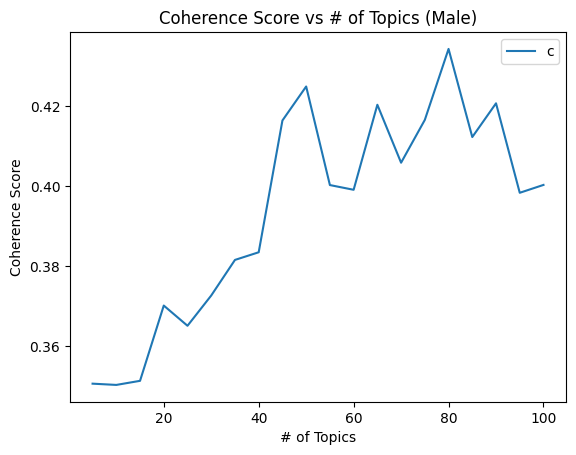

In [29]:
# display MALLET optimization for K for males
start = 5
limit = 105
step = 5
x_key = range(start, limit, step)

print(coherence_values_male)

plt.plot(x_key, coherence_values_male)
#plt.plot(np.unique(x_key), np.poly1d(np.polyfit(x_key, coherence_values_male, 8))(np.unique(x_key)))

plt.title("Coherence Score vs # of Topics (Male)")
plt.xlabel("# of Topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence_male"), loc="best")
plt.show()

[0.3548157814510561, 0.35729880450069046, 0.3557364776594883, 0.3591028339759258, 0.3786056526946936, 0.3625179157931739, 0.38996133002286104, 0.40677344704811136, 0.3948066751399619, 0.40996495092113244, 0.38019335492721773, 0.40977760320328843, 0.4377108967143066, 0.44066502987220685, 0.42927065165149697, 0.4551023306282108, 0.434529726772271, 0.43994451321117484, 0.4409046156343819, 0.44420229325889893]


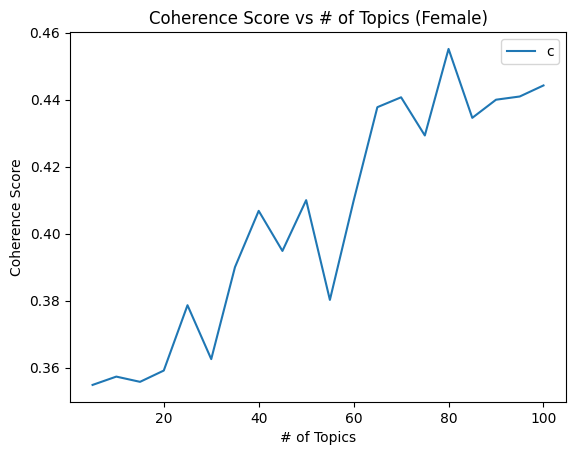

In [30]:
# display MALLET optimization for K for females
start = 5
limit = 105
step = 5
x_key = range(start, limit, step)

print(coherence_values_female)

plt.plot(x_key, coherence_values_female)
plt.title("Coherence Score vs # of Topics (Female)")
plt.xlabel("# of Topics")
plt.ylabel("Coherence Score")
plt.legend(("coherence_female"), loc="best")
plt.show()

In [44]:
# train male and female models for k=80, k=80, then walk back by k=5 until no repeated topics -> k=50, k=70

#c_v=0.424891378692681
model_male = gensim.models.wrappers.LdaMallet(mallet_path=mallet_path, corpus=corpus_male, num_topics=50,
                                        iterations=500, id2word=id2word_male, optimize_interval=1, random_seed=0)

In [64]:
#c_v=0.0.44066502987220685
model_female = gensim.models.wrappers.LdaMallet(mallet_path=mallet_path, corpus=corpus_female, num_topics=70,
                                        iterations=500, id2word=id2word_female, optimize_interval=1, random_seed=0)

In [65]:
print("===male===")
pp.pprint(model_male.print_topics())
print("===female===")
pp.pprint(model_female.print_topics())

===male===
[(4,
  '0.071*"class" + 0.040*"driver" + 0.040*"record" + 0.040*"bloodwork" + '
  '0.040*"parent" + 0.030*"passed" + 0.030*"license" + 0.030*"taking" + '
  '0.020*"period" + 0.020*"fund"'),
 (41,
  '0.196*"potassium" + 0.065*"eating" + 0.043*"electrolyte" + '
  '0.043*"nutrition" + 0.043*"hypokalemia" + 0.043*"bedridden" + 0.043*"test" '
  '+ 0.022*"theyre" + 0.022*"ma" + 0.022*"testing"'),
 (35,
  '0.062*"employed" + 0.042*"dropped" + 0.042*"menial" + 0.042*"workforce" + '
  '0.021*"speaking" + 0.021*"bro" + 0.021*"pet" + 0.021*"culture" + '
  '0.021*"option" + 0.021*"scare"'),
 (9,
  '0.127*"amp" + 0.046*"brother" + 0.040*"back" + 0.035*"wa" + 0.029*"mum" + '
  '0.029*"le" + 0.017*"crazy" + 0.017*"face" + 0.017*"crack" + 0.017*"lie"'),
 (17,
  '0.065*"animal" + 0.041*"cat" + 0.041*"human" + 0.033*"grandparent" + '
  '0.033*"humanity" + 0.024*"tired" + 0.024*"hurt" + 0.024*"edgy" + '
  '0.024*"joke" + 0.016*"cruelty"'),
 (28,
  '0.053*"addicted" + 0.040*"fucking" + 0.040*"p

In [103]:
model_female.print_topic(9)

'0.081*"feel" + 0.059*"thought" + 0.050*"ha" + 0.049*"year" + 0.048*"make" + 0.041*"talk" + 0.039*"relationship" + 0.028*"hurt" + 0.027*"back" + 0.024*"love"'

In [46]:
# export topics to csv for analysis
top_words_per_topic_male = []
for t in range(model_male.num_topics):
    top_words_per_topic_male.extend([(t, ) + x for x in model_male.show_topic(t, topn = 10)])

pd.DataFrame(top_words_per_topic_male, columns=['Topic', 'Word', 'P']).to_csv("topics_male.csv")

top_words_per_topic_female = []
for t in range(model_female.num_topics):
    top_words_per_topic_female.extend([(t, ) + x for x in model_female.show_topic(t, topn = 10)])

pd.DataFrame(top_words_per_topic_female, columns=['Topic', 'Word', 'P']).to_csv("topics_female.csv")

In [91]:
# get topic distributions & make csv
from operator import itemgetter

from statistics import mode

most_probable_topics_male = []

document_topics_male = []

for index, topics in enumerate(model_male[corpus_male]):
    document_topics_male.append([(max(topics, key=itemgetter(1))[0]), df_male.text.tolist()[index]])
    df = pd.DataFrame(document_topics_male, columns=["topic #", "text"])
    df.to_excel("male_topic_documents.xlsx")
    # get first most prob
    most_probable_topics_male.append(max(topics, key=itemgetter(1))[0])

most_probable_topics_female = []

document_topics_female = []

for index, topics in enumerate(model_female[corpus_female]):
    document_topics_female.append([(max(topics, key=itemgetter(1))[0]), df_female.text.tolist()[index]])
    df = pd.DataFrame(document_topics_female, columns=["topic #", "text"])
    df.to_excel("female_topic_documents.xlsx")
    # get first most prob
    most_probable_topics_female.append(max(topics, key=itemgetter(1))[0])

Counter({45: 31, 31: 17, 46: 14, 49: 10, 0: 10, 16: 6, 43: 4, 33: 4, 8: 4, 27: 4, 21: 4, 34: 4, 39: 3, 32: 3, 15: 3, 2: 3, 13: 3, 18: 3, 10: 2, 40: 2, 11: 2, 28: 2, 26: 2, 1: 2, 47: 2, 22: 2, 3: 2, 17: 1, 25: 1, 30: 1, 4: 1, 20: 1, 36: 1, 9: 1, 42: 1, 7: 1, 38: 1, 23: 1, 44: 1, 19: 1, 24: 1, 5: 1, 29: 1, 12: 1, 35: 1, 48: 1, 6: 1})


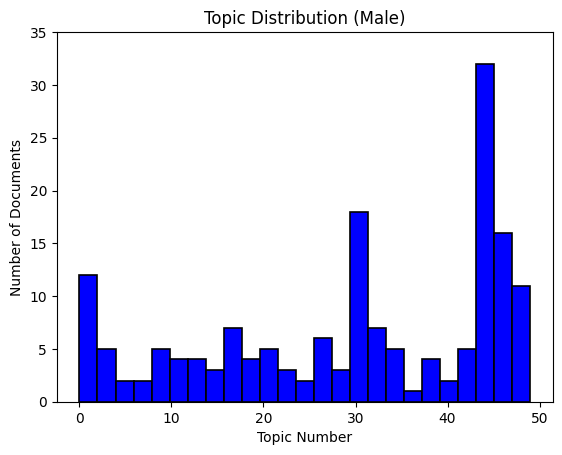

In [104]:
# display topic distribution male
plt.hist(most_probable_topics_male, bins=25, edgecolor="black", linewidth=1.2, color="blue")

from statistics import mode

plt.xlabel("Topic Number")
plt.ylabel("Number of Documents")
plt.title("Topic Distribution (Male)")

plt.yticks(range(0, 40, 5));

from collections import Counter
print(Counter(most_probable_topics_male))

Counter({51: 15, 4: 12, 9: 10, 53: 8, 30: 6, 39: 5, 38: 4, 67: 4, 3: 4, 1: 4, 47: 4, 43: 4, 5: 3, 6: 3, 15: 3, 2: 3, 57: 3, 50: 3, 60: 2, 26: 2, 45: 2, 14: 2, 10: 2, 18: 2, 23: 2, 16: 2, 32: 2, 27: 2, 12: 2, 17: 2, 52: 2, 20: 2, 8: 2, 0: 2, 33: 2, 62: 2, 37: 1, 58: 1, 40: 1, 49: 1, 46: 1, 42: 1, 66: 1, 44: 1, 31: 1, 59: 1, 54: 1, 36: 1, 19: 1, 21: 1, 48: 1, 65: 1, 13: 1, 35: 1, 25: 1, 56: 1, 64: 1, 69: 1, 11: 1, 41: 1, 29: 1, 68: 1, 7: 1, 28: 1, 34: 1, 61: 1})


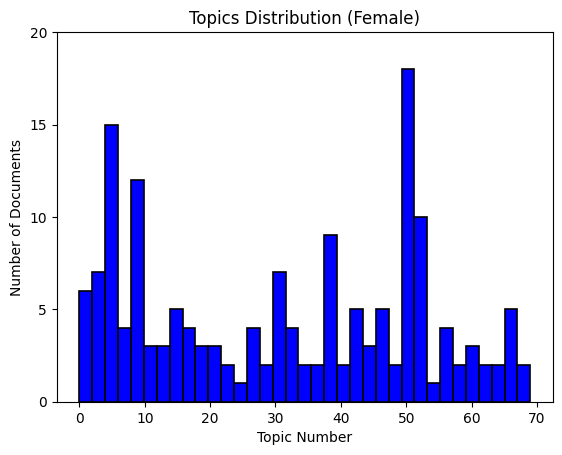

In [108]:
# display topics distribution female
plt.hist(most_probable_topics_female, bins=35, edgecolor="black", linewidth=1.2, color="blue")

plt.xlabel("Topic Number")
plt.ylabel("Number of Documents")
plt.title("Topics Distribution (Female)")

plt.yticks(range(0, 25, 5));

from collections import Counter
print(Counter(most_probable_topics_female))